In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

Загрузим данные из файла

In [224]:
file_path = "Готовые данные.csv"
df = pd.read_csv(file_path)

Объявление целевых колонок

In [225]:
target_columns = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Работа не выполнена"
]

Подготовка данных

In [226]:
X = df["comment"]  
Y = df[target_columns]

Разделение на обучающую и тестовую выборки

In [227]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Превращаем сырые тексты в удобный для модели числовой формат

In [228]:
vectorizer = TfidfVectorizer(
    max_features=10000,  
    ngram_range=(1, 2),
    stop_words=None 
)

X = vectorizer.fit_transform(df["comment"])
Y = df[target_columns]

Создание модели с pipeline

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced')))
])

Обучение модели

### LogisticRegression

In [ ]:
pipeline.fit(X_train, Y_train)

Y_pred_proba = pipeline.predict_proba(X_test)
Y_pred = pipeline.predict(X_test)

roc_auc_per_class = []
f1_scores = {}

for i, class_name in enumerate(target_columns):
    roc_auc = roc_auc_score(Y_test.iloc[:, i], Y_pred_proba[:, i])
    f1 = f1_score(Y_test.iloc[:, i], Y_pred[:, i])
    roc_auc_per_class.append(roc_auc)
    f1_scores[class_name] = f1

mean_auc_overall = np.mean(roc_auc_per_class)
mean_f1_overall = np.mean(list(f1_scores.values()))

for class_name in Y_test.columns:
    idx = target_columns.index(class_name)
    print(f"Класс: {class_name}")
    print(f"  ROC AUC : {roc_auc_per_class[idx]:.4f}")
    print(f"  F1-score: {f1_scores[class_name]:.4f}\n")

print(f"🔸 Средний ROC AUC : {mean_auc_overall:.4f}")
print(f"🔸 Средний F1-score: {mean_f1_overall:.4f}")

joblib.dump(pipeline, 'multi_label_model.pkl')

Класс: Вопрос решен
  ROC AUC : 0.8562
  F1-score: 0.8979

Класс: Нравится качество выполнения заявки
  ROC AUC : 0.7037
  F1-score: 0.3600

Класс: Нравится качество работы сотрудников
  ROC AUC : 0.8800
  F1-score: 0.7297

Класс: Нравится скорость отработки заявок
  ROC AUC : 0.9450
  F1-score: 0.8186

Класс: Понравилось выполнение заявки
  ROC AUC : 0.8150
  F1-score: 0.6942

Класс: Работа не выполнена
  ROC AUC : 0.9773
  F1-score: 0.7708

🔸 Средний ROC AUC : 0.8629
🔸 Средний F1-score: 0.7119


Визуализация 

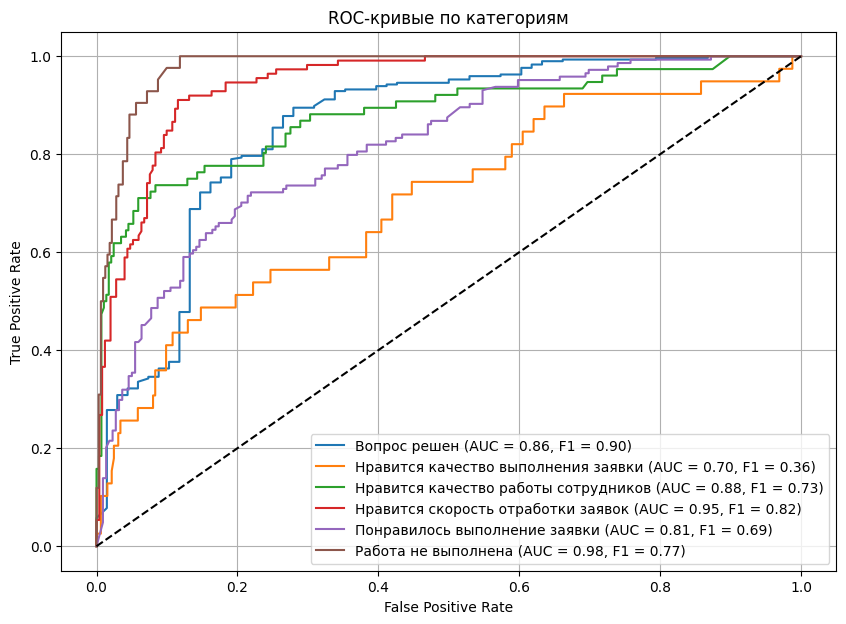

In [231]:
fpr = []
tpr = []

for i, class_name in enumerate(target_columns):
    fpr_class, tpr_class, _ = roc_curve(Y_test.iloc[:, i], Y_pred_proba[:, i])
    fpr.append(fpr_class)
    tpr.append(tpr_class)


plt.figure(figsize=(10, 7))

for i, class_name in enumerate(target_columns):
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc_per_class[i]:.2f}, F1 = {f1_scores[class_name]:.2f})")

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по категориям")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
